<a href="https://colab.research.google.com/github/rameshavinash94/Retail-Store-Analysis/blob/main/Project_Retail_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Retail Store Analysis**


**Project Motivation**


**Clustering**:
Customer segmentation and to get a better understanding of the group of customers who are at risk of churn so that retail stores can proactively engage with such customers to retain them.


**Classification**:
Upon analyzing and segmenting the customers based on their buying pattern, we are classifying customers based on their total worth to a business over the whole period of their relationship (Customer Lifetime Value)


**Regression**:
Predicting the product delivery date, a factor that influences the most to keep the customer satisfied.


## **Dataset**

The dataset contains information of 100k orders placed in numerous Brazilian markets between 2016 and 2018. This is real business information that has been anonymized. Olist, the largest department store in Brazil, has generously shared this data collection. Olist connects small businesses from all around Brazil to the channel in a simple and cost-effective manner. The merchant can sell their products on the Olist Store and have them transported straight to customers through the Olist logistics partner. The vendor will be alerted to complete the order once the buyer has purchased the product from the Olist Store.When the client receives the product or the estimated delivery date approaches, the customer receives an email with a satisfaction survey where he or she can leave a note and some remarks on the purchase experience.

[Brazilian Olist Retail store dataset](https://www.kaggle.com/olistbr/brazilian-ecommerce/)


In [ ]:
# opendatasets is a Python library for downloading datasets from online sources like Kaggle and Google Drive using a simple Python command. 
!pip install opendatasets --upgrade --quiet

In [ ]:
# Importing Libraries

# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
import opendatasets as od
from datetime import datetime
import calendar
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings("ignore")

# DataPrep
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# For Metrics analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from time import time
from sklearn.metrics import plot_confusion_matrix
from yellowbrick.classifier import ROCAUC

# For Interactive dashboard
from imblearn.over_sampling import SMOTE 
import ipywidgets as widgets
from IPython.display import display, clear_output
from collections import Counter

In [ ]:
# Downloading dataset from kaggle
download_url = 'https://www.kaggle.com/olistbr/brazilian-ecommerce/download'

od.download(download_url)

Skipping, found downloaded files in "./brazilian-ecommerce" (use force=True to force download)


In [ ]:
data = pd.read_csv("/content/olist_customers_dataset.csv")
geo_data = pd.read_csv("/content/brazilian-ecommerce/olist_geolocation_dataset.csv")
order_itemdata = pd.read_csv("/content/brazilian-ecommerce/olist_order_items_dataset.csv")
pay_data = pd.read_csv("/content/brazilian-ecommerce/olist_order_payments_dataset.csv")
rev_data = pd.read_csv("/content/brazilian-ecommerce/olist_order_reviews_dataset.csv")
orders = pd.read_csv("/content/brazilian-ecommerce/olist_orders_dataset.csv")
order_prddata = pd.read_csv("/content/brazilian-ecommerce/olist_products_dataset.csv")
order_selldata = pd.read_csv("/content/brazilian-ecommerce/olist_sellers_dataset.csv")
order_prd_catdata = pd.read_csv("/content/brazilian-ecommerce/product_category_name_translation.csv")

## **Exploratory Data Analysis**

**Check number of columns and rows in all datasets**



In [ ]:
datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]



info_df = pd.DataFrame({},)
info_df['dataset']= titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['columns_name']= [', '.join(list(df.columns)) for df in datasets] 
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Blues_r')

,dataset,no_of_columns,columns_name,no_of_rows
0,customers,5,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441
1,geolocations,5,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163
2,items,7,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650
3,payments,5,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886
4,orders,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441
5,products,9,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951
6,reviews,7,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",99224
7,sellers,4,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095
8,category_translation,2,"product_category_name, product_category_name_english",71


**Observations:**

Dataset with maximum number of columns is products.

Dataset with maximum number of rows is geolocations.

**Checking dtypes**

In [ ]:
datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset']= titles

new_df['numeric_features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
new_df['num_features_name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
new_df['object_features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
new_df['objt_features_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
new_df['bool_features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
new_df.style.background_gradient(cmap='Blues_r')

,dataset,numeric_features,num_features_name,object_features,objt_features_name,bool_features
0,customers,1,customer_zip_code_prefix,4,"customer_id, customer_unique_id, customer_city, customer_state",0
1,geolocations,3,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng",2,"geolocation_city, geolocation_state",0
2,items,3,"order_item_id, price, freight_value",4,"order_id, product_id, seller_id, shipping_limit_date",0
3,payments,3,"payment_sequential, payment_installments, payment_value",2,"order_id, payment_type",0
4,orders,0,,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",0
5,products,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",2,"product_id, product_category_name",0
6,reviews,1,review_score,6,"review_id, order_id, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",0
7,sellers,1,seller_zip_code_prefix,3,"seller_id, seller_city, seller_state",0
8,category_translation,0,,2,"product_category_name, product_category_name_english",0


**Observations:**

products dataset has maximum number of numerical features(i.e dtype :'int16', 'int32', 'int64', 'float16', 'float32', 'float64').

Orders dataset has maximum number of features of object dtype.

We can also observe that all the timestamps are in object datatypes.So, we have to convert it into datetime type to do analysis on these features.

**Checking no of null values**

In [ ]:
#code source-https://www.kaggle.com/fayhosseini/brazilian-e-commerce-eda-for-beginners

datasets = [data,geo_data,order_itemdata, pay_data, orders, order_prddata,rev_data,order_selldata, order_prd_catdata]
titles = ["customers","geolocations","items", "payments", "orders", "products","reviews","sellers","category_translation"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset 
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset 
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values 
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

#creating column of name of columns in the dataset with null-values 
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Blues_r')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,geolocations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
5,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
6,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,145903,2,"review_comment_title, review_comment_message"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",4,0,0,
8,category_translation,"product_category_name, product_category_name_english",2,0,0,


**Observations**

The maximum number of null-values are present in reviews dataset and the name of the columns with the null-values are review_comment_title and review_comment_message.

Products dataset contains least number of null- values but most of its columns has null-values.

**Eliminating review columns**

In [ ]:
rev_new = rev_data.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp'],axis=1)

**Merging all datasets**

In [ ]:
df = pd.merge(orders,pay_data, on="order_id")
df = df.merge(data, on="customer_id")
df = df.merge(order_itemdata, on="order_id")
df = df.merge(order_prddata, on="product_id")
df = df.merge(order_prd_catdata, on="product_category_name")
df = df.merge(rev_new, on="order_id")
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ..."


In [ ]:
df.shape

(115609, 33)

**Handling missing values**

In [ ]:
df.isnull().sum()

order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                   14
order_delivered_carrier_date      1195
order_delivered_customer_date     2400
order_estimated_delivery_date        0
payment_sequential                   0
payment_type                         0
payment_installments                 0
payment_value                        0
customer_unique_id                   0
customer_zip_code_prefix             0
customer_city                        0
customer_state                       0
order_item_id                        0
product_id                           0
seller_id                            0
shipping_limit_date                  0
price                                0
freight_value                        0
product_category_name                0
product_name_lenght                  0
product_description_lenght           0
product_photos_qty       

**Observations**

Timestamps containg missing values are order_approved_at, order_delivered_carrier_date, order_delivered_customer_date.

Null-values in order_approved_at can be replaced by order_purchase_timestamp and
null-values in order_delivered_customer_date can be replaced by order_estimated_delivery_date

we can drop the column order_delivered_carrier_date.

Product related details can be filled by taking median of those columns.

Review comments can be filled using "No review" string.

In [ ]:
index = (df[df['order_delivered_customer_date'].isnull() == True].index.values)

# null values in order_approved_at replaced by order_purchase_timestamp.
df["order_approved_at"].fillna(df["order_purchase_timestamp"], inplace=True)

# null values in order_delivered_customer_date replaced by order_estimated_delivery_date.
df["order_delivered_customer_date"].fillna(df["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
df.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [ ]:
# Handling missing product dimension values 
df['product_weight_g'].fillna(df['product_weight_g'].median(),inplace=True)
df['product_length_cm'].fillna(df['product_length_cm'].median(),inplace=True)
df['product_height_cm'].fillna(df['product_height_cm'].median(),inplace=True)
df['product_width_cm'].fillna(df['product_width_cm'].median(),inplace=True)

In [ ]:
#Handling missing values of text column
print("Percentage of null reviews :",(df.review_comment_message.isnull().sum()/len(df))*100 ,"%")
# filling null value of review comments with no_review
df['review_comment_message'].fillna('nao_reveja',inplace=True)

Percentage of null reviews : 57.697065107387836 %


In [ ]:
df.shape

(115609, 32)

**Data Deduplication**

In [ ]:
dup_rows = df[df.duplicated(['order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date','customer_unique_id','review_comment_message'])]
dup_rows.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
8,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,2,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
9,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,3,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja
10,82bce245b1c9148f8d19a55b9ff70644,388025bec8128ff20ec1a316ed4dcf02,delivered,2017-04-20 17:15:46,2017-04-21 05:15:56,2017-05-10 09:17:55,2017-05-12 00:00:00,1,boleto,1,267.80,f9effeed3df9ae063a58c0759b96f8b2,85804,cascavel,PR,4,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-04-27 05:15:56,38.00,15.56,utilidades_domesticas,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,1,nao_reveja


In [ ]:
#Deduplication of entries
df= df.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'}, keep='first', inplace=False)
df=df.reindex()
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ..."
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,3,nao_reveja
6,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21 00:00:00,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,1,"Inicialmente, na data da compra o produto era ..."


In [ ]:
df.shape

(96516, 32)

## **Data Visualization**

In [ ]:
# Converting the delivery and purchase timestamp to date and time format using pandas
df[['order_purchase_timestamp', 'order_delivered_customer_date']]=df[['order_purchase_timestamp', 'order_delivered_customer_date']].apply(pd.to_datetime)

df['Year'] = df['order_purchase_timestamp'].dt.year

year_value = df.groupby('Year').size()
year_name = year_value.index

fig = px.pie(df["Year"], values=year_value, names=year_name, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Pie chart shows the the increase in sales every year from 2016 to 2018.

In [ ]:
# Understand which month and day has more sales, which helps retailers to offer promotions.

df['Month'] =  pd.Series(pd.Categorical(df['order_purchase_timestamp'].dt.month_name(), categories=list(calendar.month_name)[1:]))

month_values = df.groupby('Month').size()
month_names = list(calendar.month_name)[1:]

fig = px.bar(df, x=month_values, y=month_names, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

From the above graph we can depict that the August is month which has more sales in Brazil.

In [ ]:
# Understanding sales by day
df['Day'] =  pd.Series(pd.Categorical(df['order_purchase_timestamp'].dt.day_name(), categories=list(calendar.day_name)))

day_values = df.groupby('Day').size()
day_names = list(calendar.day_name)

fig = px.bar(df, x=day_values, y=day_names, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Monday is where most of the orders are placed by the customers.

In [ ]:
# Understanding Product sales
product_name = df["product_category_name_english"].value_counts().sort_values(ascending=False)[:10]

fig = px.bar(df, x=product_name.values, y=product_name.index, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Bed_bath_table followed by health_beauty has the highest sales across Brazil.

In [ ]:
# Understanding the payment mode
df["payment_type"].replace({"not_defined": "credit_card"}, inplace=True)
df['payment_type'] = df['payment_type'].fillna("credit_card")

paymt_type = df.payment_type.unique()
values = df["payment_type"].value_counts()

fig = px.pie(df["payment_type"], values=values, names=paymt_type, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Almost 3/4th of the customers use credit card to buy the products, offering discount on credit card will increase sales.

In [ ]:
# Understanding which state has more customers
state = df.customer_state.unique()
customer_count = df["customer_state"].value_counts()

fig = px.bar(df, x=customer_count, y=state, color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()

Sao Paulo state has highest customer for this retail store.

**Univariate Analysis on Numerical Features**

**Price**

<Figure size 576x396 with 0 Axes>

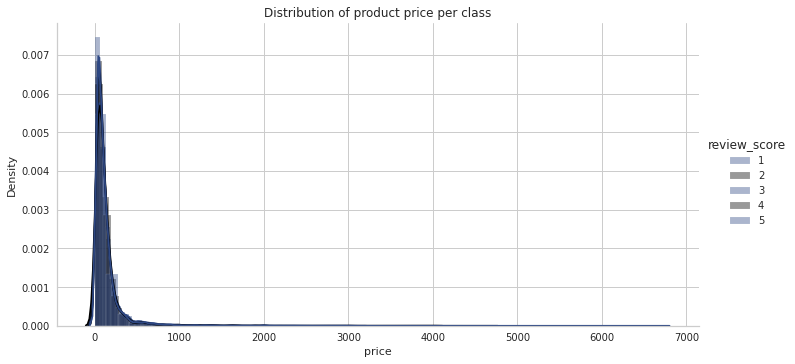

In [ ]:
import seaborn as sns

plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "price").add_legend();
plt.title('Distribution of product price per class')
plt.show()

* The above distribution plot shows the distribution of price for both the postive and negative classes. We can observe that there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on price feature.

**Freight_value**

<Figure size 576x396 with 0 Axes>

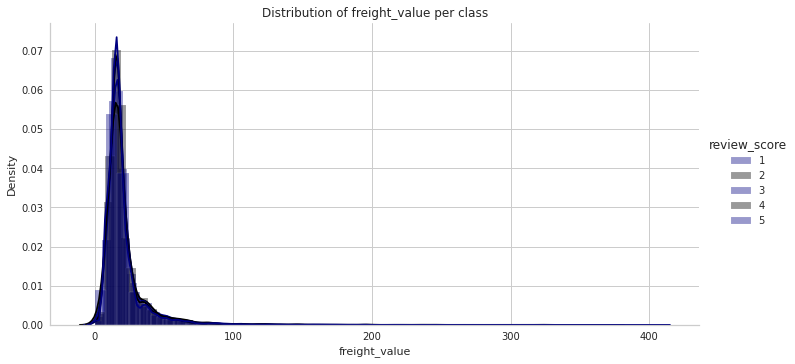

In [ ]:
# plotting distributions of freight_value per class
plt.figure()
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#000080','black'])
ax = ax.map(sns.distplot, "freight_value").add_legend();
plt.title('Distribution of freight_value per class')
plt.show()

* The above distribution plot shows the distribution of freight_value for both the postive and negative classes. We can observe that there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on freight_value feature.

**product_height_cm**

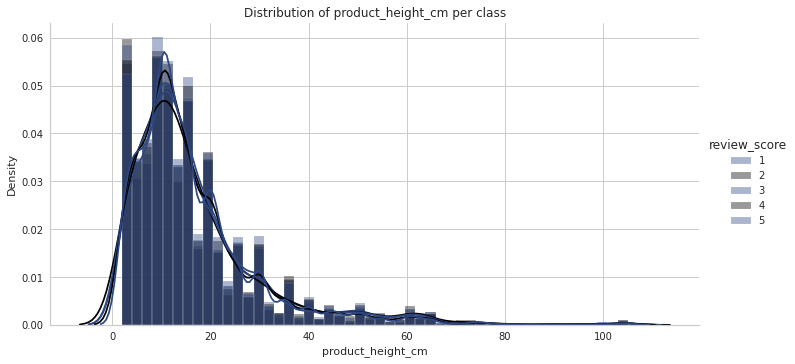

In [ ]:
# plotting distributions of product_height_cm per class
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "product_height_cm").add_legend();
plt.title('Distribution of product_height_cm per class')
plt.show()

* The above distribution plot shows the distribution of product_height_cm for both the postive and negative classes. We can observe that most of the product has height less than 20 .Also, there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on product_height_cm feature.

**product_weight_g**

<Figure size 576x396 with 0 Axes>

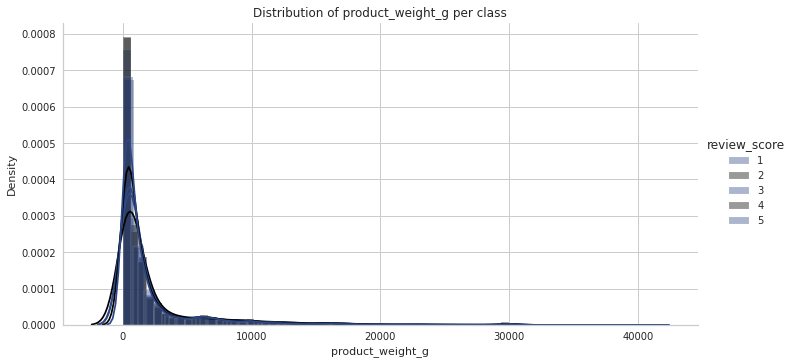

In [ ]:
# distriution plot of product_weight_g
plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "product_weight_g").add_legend();
plt.title('Distribution of product_weight_g per class')
plt.show()

* The above distribution plot shows the distribution of product_weight_g for both the postive and negative classes. We can observe that most of the product has weight less than 5000 gm .Also, there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on product_weight_g feature.

**payment_value**

<Figure size 576x396 with 0 Axes>

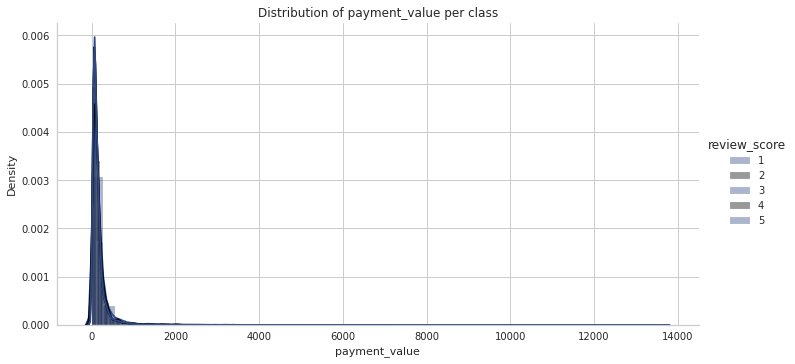

In [ ]:
# distriution plot of payment_value
plt.figure()
sns.set_style("whitegrid")
ax = sns.FacetGrid(df, hue="review_score", height=5,aspect=2.0,palette=['#2e4884','black'])
ax = ax.map(sns.distplot, "payment_value").add_legend();
plt.title('Distribution of payment_value per class')
plt.show()

* The above distribution plot shows the distribution of payment_value for both the postive and negative classes. We can observe that there is almost completely overlap of both the distribution for positive and negative class which suggests that it is not possible to classify them based only on payment_value feature.

# **Clustering:**


Customer segmentation and to get a better understanding of the group of customers who are at risk of churn so that retail stores can proactively engage with such customers to retain them.

### **Feature Extraction**

RFM is a method used to analyze customer value. RFM stands for RECENCY, Frequency, and Monetary.

**Recency**: How recently did the customer visit our website or how recently did a customer purchase?

**Frequency**: How often do they visit or how often do they purchase?

**Monetary**: How much revenue we get from their visit or how much do they spend when they purchase?

In [ ]:
# https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
PRESENT = datetime(2018,9,3)
rfm= df.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date: (PRESENT - date.max()).days,
                                        'order_id': lambda num: len(num),
                                        'payment_value': lambda price: price.sum()})
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm['frequency'] = rfm['frequency'].astype(int)
rfm['monetary'] = rfm['monetary'].astype(float)

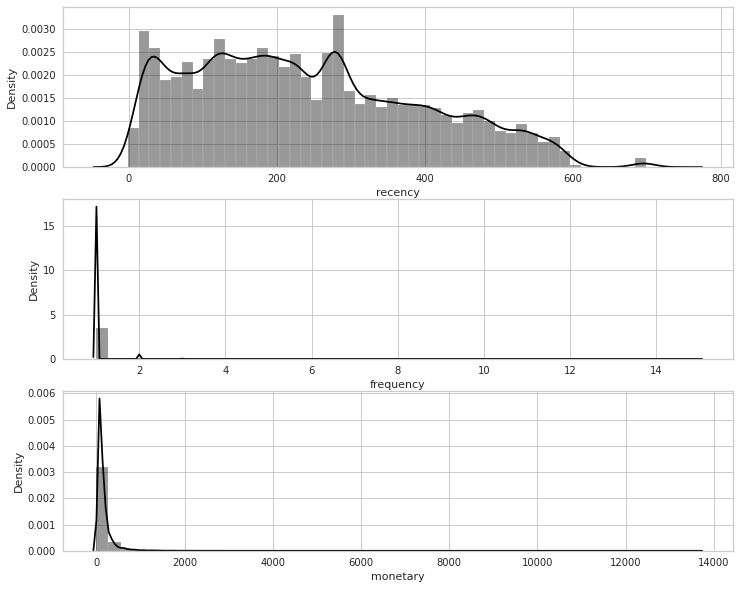

In [ ]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['recency'],color='black')
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(rfm['frequency'],color='black')
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['monetary'],color='black')
# Show the plot
plt.show()

**Observation(s)**


There are three density plots of recency, frequency and monetary are plotted.From the first plot of recency we can observe that most of the users stayed with olist for long duration which is positive thing but order frequency is less.

from the second plot of frequency most number of transaction or order is less than 5. from the third plot of monetary the maximum amount spend over the given very period is seems to less than 1500 approx.

In [ ]:
# Create labels for Recency and Frequency
def partition(x):
    if x < 10:
      return 1
    if 10<=x<=35:
      return 2
    if 35<x<=50:
      return 3
    if 50<x<=75:
      return 4      

rfm['f_quartile']=rfm['frequency'].map(lambda cw : partition(cw) ) 
    
# checking the review score now
rfm.f_quartile.value_counts()
r_labels = range(4, 0, -1);m_labels= range(1,5)

rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, r_labels)
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, m_labels)

In [ ]:
rfm['r_percentile'] = rfm['recency'].rank(pct=True,ascending=False)
rfm['r_quartile'] = pd.cut(rfm['r_percentile'], 4, labels=range(4,0,-1))
rfm['f_percentile'] = rfm['frequency'].rank(pct=True,ascending=True)
rfm['f_quartile'] = pd.cut(rfm['f_percentile'], 4, labels=range(4,0,-1))
rfm['m_percentile'] = rfm['monetary'].rank(pct=True,ascending=True)
rfm['m_quartile'] = pd.cut(rfm['m_percentile'], 4, labels=range(4,0,-1))

In [ ]:
# Generating RFM-scores
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,r_percentile,f_percentile,RFM_Score,m_percentile
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,4,1,2,0.759096,0.484978,142,0.639599
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4,2,4,0.748721,0.484978,244,0.032191
0000f46a3911fa3c0805444483337064,541,1,86.22,4,4,3,0.035510,0.484978,443,0.403770
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,4,3,4,0.286683,0.484978,344,0.133678
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,4,3,1,0.336888,0.484978,341,0.782191


In [ ]:
# summing up rfm scores
rfm_count_unique = rfm.groupby('RFM_Score')['RFM_Score'].nunique()
print(rfm_count_unique.sum())
rfm['RFM_Score_s'] = rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)

32


In [ ]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score_s'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score_s'] >= 8) and (df['RFM_Score_s'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score_s'] >= 7) and (df['RFM_Score_s'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score_s'] >= 6) and (df['RFM_Score_s'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score_s'] >= 5) and (df['RFM_Score_s'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score_s'] >= 4) and (df['RFM_Score_s'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,r_percentile,f_percentile,RFM_Score,m_percentile,RFM_Score_s,RFM_Level
customer_unique_id,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,4,1,2,0.759096,0.484978,142,0.639599,7.0,Loyal
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4,2,4,0.748721,0.484978,244,0.032191,10.0,Can't Loose Them
0000f46a3911fa3c0805444483337064,541,1,86.22,4,4,3,0.035510,0.484978,443,0.403770,11.0,Can't Loose Them
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,4,3,4,0.286683,0.484978,344,0.133678,11.0,Can't Loose Them
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,4,3,1,0.336888,0.484978,341,0.782191,8.0,Champions


**K-Means clustering**

In [ ]:
features_used = rfm[['f_quartile', 'r_quartile', 'm_quartile', 'RFM_Score_s']]

In [ ]:
# Create the K means model for different values of K
def try_different_clusters(K, data):
       
    cluster_values = list(range(1, K+1))
    inertias=[]
    
    for c in cluster_values:
        model = KMeans(n_clusters = c,init='k-means++',max_iter=400,random_state=42)
        model.fit(data)
        inertias.append(model.inertia_)
    
    return inertias

In [ ]:
# Find output for k values between 1 to 12 
outputs = try_different_clusters(12, rfm[['f_quartile', 'r_quartile', 'm_quartile', 'RFM_Score_s']])
distances = pd.DataFrame({"clusters": list(range(1, 13)),"sum of squared distances": outputs})

In [ ]:
# Finding optimal number of clusters k
figure = go.Figure()
figure.add_trace(go.Scatter(x=distances["clusters"], y=distances["sum of squared distances"]))

figure.update_layout(xaxis = dict(tick0 = 1,dtick = 1,tickmode = 'linear'),                  
                  xaxis_title="Number of clusters",
                  yaxis_title="Sum of squared distances",
                  title_text="Finding optimal number of clusters using elbow method")
figure.show()

In [ ]:
# Re-Train K means model with k=5
kmeans_model_new = KMeans(n_clusters = 5, init='k-means++',max_iter=400,random_state=42)

kmeans_model_new.fit_predict(rfm[['f_quartile', 'r_quartile', 'm_quartile', 'RFM_Score_s']])

array([0, 1, 2, ..., 4, 0, 2], dtype=int32)

In [ ]:
# Create data arrays
cluster_centers = kmeans_model_new.cluster_centers_
data = np.expm1(cluster_centers)
points = np.append(data, cluster_centers, axis=1)
points

array([[5.35981500e+01, 3.05465028e+00, 5.10981096e+00, 1.35156798e+03,
        4.00000000e+00, 1.39986444e+00, 1.80989583e+00, 7.20976027e+00],
       [5.33721393e+01, 6.47802756e+00, 3.21863576e+01, 1.34924521e+04,
        3.99585188e+00, 2.01196906e+00, 3.50213888e+00, 9.50995982e+00],
       [5.35981500e+01, 3.85959618e+01, 3.79400650e+01, 8.41822128e+04,
        4.00000000e+00, 3.67872714e+00, 3.66202367e+00, 1.13407508e+01],
       [1.71828183e+00, 9.16934240e+00, 3.33711802e+00, 1.18891555e+02,
        1.00000000e+00, 2.31937755e+00, 1.46721008e+00, 4.78658763e+00],
       [5.30316760e+01, 3.20163798e+01, 3.54122599e+00, 8.10023082e+03,
        3.98957047e+00, 3.49700380e+00, 1.51319702e+00, 8.99977128e+00]])

In [ ]:
# Add "clusters" to customers data
points = np.append(points, [[0], [1], [2], [3], [4]], axis=1)
rfm["clusters"] = kmeans_model_new.labels_

In [ ]:
# visualize clusters
figure = px.scatter_3d(rfm,
                    color='clusters',
                    x="recency",
                    y="frequency",
                    z="monetary",            
                    category_orders = {"clusters": ["0", "1", "2", "3", "4"]}                    
                    )
figure.update_layout()
figure.show()

In [ ]:
golden_cluster = rfm.loc[rfm['clusters'] == 1, ['recency', 'frequency', 'monetary', 'RFM_Score_s', 'f_quartile', 'r_quartile', 'm_quartile', 'RFM_Level']]
golden_cluster.head()

,recency,frequency,monetary,RFM_Score_s,f_quartile,r_quartile,m_quartile,RFM_Level
customer_unique_id,,,,,,,,
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,10.0,4,2,4,Can't Loose Them
00050ab1314c0e55a6ca13cf7181fecf,135,1,35.38,10.0,4,2,4,Can't Loose Them
00090324bbad0e9342388303bb71ba0a,162,1,63.66,9.0,4,2,3,Can't Loose Them
000949456b182f53c18b68d6babc79c1,132,1,82.05,9.0,4,2,3,Can't Loose Them
000e309254ab1fc5ba99dd469d36bdb4,69,1,8.53,9.0,4,1,4,Can't Loose Them


In [ ]:
# Find output for k values between 1 to 5
outputs = try_different_clusters(5, golden_cluster[['f_quartile', 'r_quartile', 'm_quartile', 'RFM_Score_s']])
distances = pd.DataFrame({"clusters": list(range(1, 6)),"sum of squared distances": outputs})

In [ ]:
# Finding optimal number of clusters k
figure = go.Figure()
figure.add_trace(go.Scatter(x=distances["clusters"], y=distances["sum of squared distances"]))

figure.update_layout(xaxis = dict(tick0 = 1,dtick = 1,tickmode = 'linear'),                  
                  xaxis_title="Number of clusters",
                  yaxis_title="Sum of squared distances",
                  title_text="Finding optimal number of clusters using elbow method")
figure.show()

In [ ]:
# Re-Train K means model with k=2
kmeans_model_new = KMeans(n_clusters = 2, init='k-means++',max_iter=400,random_state=42)

kmeans_model_new.fit_predict(golden_cluster[['f_quartile', 'r_quartile', 'm_quartile', 'RFM_Score_s']])

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# Create data arrays
cluster_centers = kmeans_model_new.cluster_centers_
data = np.expm1(cluster_centers)
points = np.append(data, cluster_centers, axis=1)
points

array([[5.35030865e+01, 4.31462156e+00, 3.84002780e+01, 1.14118137e+04,
        3.99825733e+00, 1.67046181e+00, 3.67377287e+00, 9.34249201e+00],
       [5.29936473e+01, 1.91602169e+01, 1.91602169e+01, 2.19438726e+04,
        3.98886640e+00, 3.00371120e+00, 3.00371120e+00, 9.99628880e+00]])

In [ ]:
# Add "clusters" to customers data
points = np.append(points, [[0], [1]], axis=1)
golden_cluster["fractral_clusters"] = kmeans_model_new.labels_

In [ ]:
# visualize clusters
figure = px.scatter_3d(golden_cluster,
                    color='fractral_clusters',
                    x="recency",
                    y="frequency",
                    z="monetary",            
                    category_orders = {"fractral_clusters": ["0", "1"]}                    
                    )
figure.update_layout()
figure.show()

### **Conclusion:**

By perform fractural clustering we were able to come up with the golden cluster ie., group of customers who are about to churn.

In [ ]:
# complete dataset for furthur analysis
df = df.merge(rfm, how='left', on='customer_unique_id')

In [ ]:
df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,review_score,review_comment_message,Year,Month,Day,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,r_percentile,f_percentile,RFM_Score,m_percentile,RFM_Score_s,RFM_Level,clusters
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,"Não testei o produto ainda, mas ele veio corre...",2017,October,Monday,335,2,62.23,1,3,3,0.271575,0.983768,313,0.255321,7.0,Loyal,3
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,4,Deveriam embalar melhor o produto. A caixa vei...,2017,October,Monday,383,1,37.77,4,4,4,0.204672,0.484978,444,0.095941,12.0,Can't Loose Them,2
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,5,"Só achei ela pequena pra seis xícaras ,mais é ...",2017,November,Friday,396,1,37.77,4,4,4,0.187042,0.484978,444,0.095941,12.0,Can't Loose Them,2
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,3,nao_reveja,2017,April,Thursday,314,1,44.09,4,3,4,0.303637,0.484978,344,0.136880,11.0,Can't Loose Them,2
4,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21 00:00:00,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.00,17.12,utilidades_domesticas,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,1,"Inicialmente, na data da compra o produto era ...",2017,May,Monday,282,1,356.12,4,3,1,0.362044,0.484978,341,0.919124,8.0,Champions,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96511,2cfc3681e512e0d12b6fe84b396e3907,6c60b00bcbef919c1697d18c309a99fe,delivered,2018-04-22 20:15:52,2018-04-24 18:46:28,2018-04-30 20:51:45,2018-05-18 00:00:00,1,credit_card,1,34.22,4637328fb3cc446c747c7f83f80c651d,38401,uberlandia,MG,1,1cf657de01c2b973b898ad0ac9073ac7,fd386aa7bed2af3c7035c65506c9b4a3,2018-04-26 21:31:05,15.99,18.23,artes_e_artesanato,41.0,130.0,1.0,210.0,25.0,10.0,15.0,

# **Regression:**

Predicting the product delivery date, a factor that influences the most to keep the customer satisfied.

In [ ]:
#DROP COLUMNS THAT ARE NOT NEEDED

df_regression = df[['order_id','product_id', 'customer_id', 'order_status', 'price', 'freight_value', 
         'order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date',
        'customer_state', 'product_description_lenght', 'product_photos_qty', 'review_score', 'product_category_name_english']]

**Target Variable Creation : delivery Time**

In [ ]:
df_regression['order_purchase_timestamp'] = pd.to_datetime(df_regression['order_purchase_timestamp'])
df_regression['order_approved_at'] = pd.to_datetime(df_regression['order_approved_at'])
df_regression['order_estimated_delivery_date'] = pd.to_datetime(df_regression['order_estimated_delivery_date'])
df_regression['order_delivered_customer_date'] = pd.to_datetime(df_regression['order_delivered_customer_date'])

In [ ]:
# Days Estimated Delivery Time
df_regression['estimated_delivery_time'] = (df_regression.loc[:,'order_estimated_delivery_date'] - df_regression.loc[:,'order_approved_at'])
df_regression['estimated_delivery_time'] = df_regression['estimated_delivery_time'].dt.days

In [ ]:
# Days Actual Delivery Time
df_regression['actual_delivery_time'] = (df_regression.loc[:,'order_delivered_customer_date'] - df_regression.loc[:,'order_approved_at'])
df_regression['actual_delivery_time'] = df_regression['actual_delivery_time'].dt.days

Only taking values greater than 0 as the least number of days it takes to deliver an order should be 1

In [ ]:
df_regression = df_regression.loc[df_regression['estimated_delivery_time'] > 0]
df_regression = df_regression.loc[df_regression['actual_delivery_time'] > 0]

Dropping other datetime features

In [ ]:
cols2drop = ['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 'order_delivered_customer_date']
df_regression.drop(cols2drop, axis=1, inplace=True)
df_regression.head()

,order_id,product_id,customer_id,order_status,price,freight_value,customer_state,product_description_lenght,product_photos_qty,review_score,product_category_name_english,estimated_delivery_time,actual_delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,9ef432eb6251297304e76186b10a928d,delivered,29.99,8.72,SP,268.0,4.0,4,housewares,15,8
1,128e10d95713541c87cd1a2e48201934,87285b34884572647811a353c7ac498a,a20e8105f23924cd00833fd87daa0831,delivered,29.99,7.78,SP,268.0,4.0,4,housewares,12,2
2,0e7e841ddf8f8f2de2bad69267ecfbcf,87285b34884572647811a353c7ac498a,26c7ac168e1433912a51b924fbd34d34,delivered,29.99,7.78,SP,268.0,4.0,5,housewares,12,4
3,bfc39df4f36c3693ff3b63fcbea9e90a,87285b34884572647811a353c7ac498a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,29.99,14.10,SC,268.0,4.0,3,housewares,18,13
4,6ea2f835b4556291ffdc53fa0b3b95e8,be021417a6acb56b9b50d3fd2714baa8,c7340080e394356141681bd4c9b8fe31,delivered,339.00,17.12,SP,664.0,6.0,1,housewares,25,33


Removing the features that will not be useful

In [ ]:
del df_regression['order_id']
del df_regression['product_id']
del df_regression['customer_id']
del df_regression['order_status']

**correlation_matrix**

actual_delivery_time          1.000000
estimated_delivery_time       0.398991
freight_value                 0.211957
price                         0.062725
product_description_lenght    0.003891
product_photos_qty           -0.028210
review_score                 -0.358350
Name: actual_delivery_time, dtype: float64


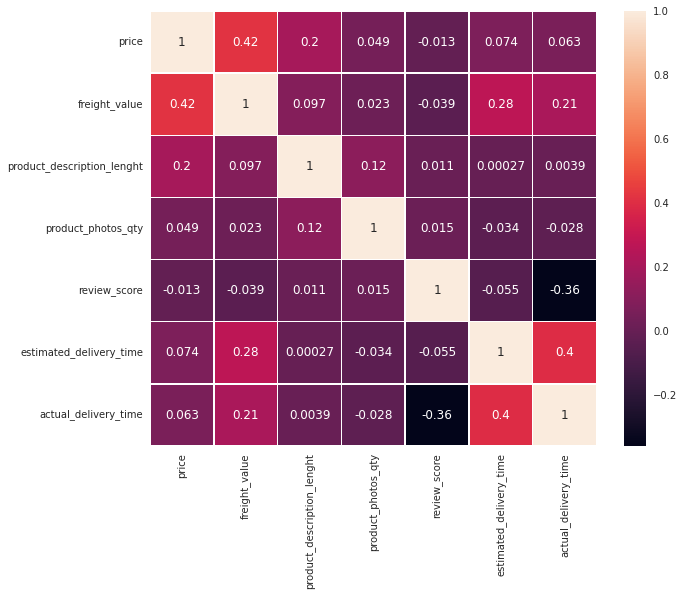

In [ ]:
corr_matrix = df_regression.corr()
print(corr_matrix['actual_delivery_time'].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(10,8))
hm = sns.heatmap(corr_matrix, annot = True, linewidths=.5, ax = ax)

**Ploting histogram of features**

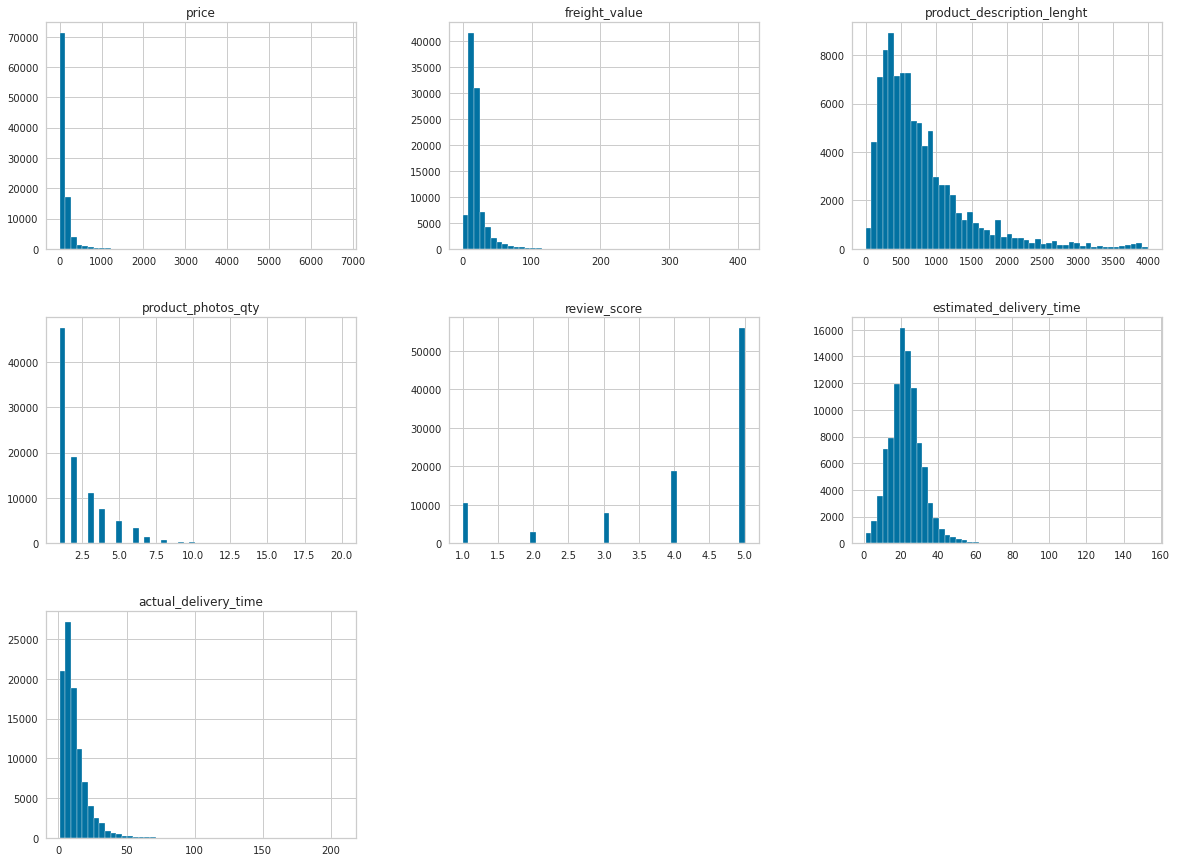

In [ ]:
%matplotlib inline

df_regression.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

Converting price to float and checking null values

In [ ]:
df_regression['price'] = pd.to_numeric(df_regression['price'])
df_regression = df_regression[df_regression['price'].notnull()]

In [ ]:
print("Skewness: \n",df_regression.skew(),"\n")
print("Kurtosis: \n",df_regression.kurtosis(),"\n")

Skewness: 
 price                         7.464575
freight_value                 5.588332
product_description_lenght    1.992794
product_photos_qty            1.859429
review_score                 -1.398314
estimated_delivery_time       0.992360
actual_delivery_time          3.660839
dtype: float64 

Kurtosis: 
 price                         103.574314
freight_value                  58.352095
product_description_lenght      4.839593
product_photos_qty              4.587948
review_score                    0.632399
estimated_delivery_time         5.306384
actual_delivery_time           35.979139
dtype: float64 



**Performing Log transformation as data is skewed**

In [ ]:
def  plot_feature(plot_1, plot_1_title, plot_2, plot_2_title):
  plt.figure(figsize=(12,10))

  plt.subplot(221)
  g = sns.distplot(plot_1)#df_regression['price']
  g.set_title( plot_1_title + "- Distribution", fontsize=15)
  g.set_xlabel("")
  g.set_ylabel("Frequency", fontsize=12)

  plt.subplot(222)
  g1 = sns.distplot(plot_2) #df_regression['freight_value']
  g1.set_title(plot_2_title + "- Distribution", fontsize=15)
  g1.set_xlabel("")
  g1.set_ylabel("Frequency", fontsize=12)

**Price and Freight value**

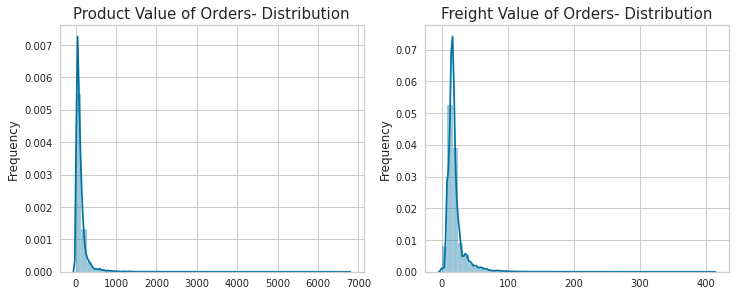

In [ ]:
plot_feature(df_regression['price'], "Product Value of Orders", df_regression['freight_value'], "Freight Value of Orders")

In [ ]:
df_regression['price'] = np.log1p(df_regression['price'])
df_regression['freight_value'] = np.log1p(df_regression['freight_value'])

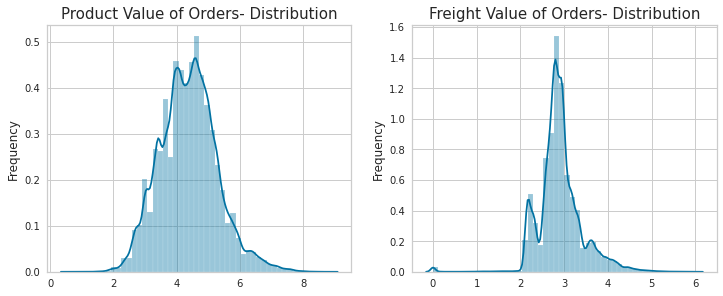

In [ ]:
plot_feature(df_regression['price'], "Product Value of Orders", df_regression['freight_value'], "Freight Value of Orders")

**Estimated delivery date and actual delivery date**

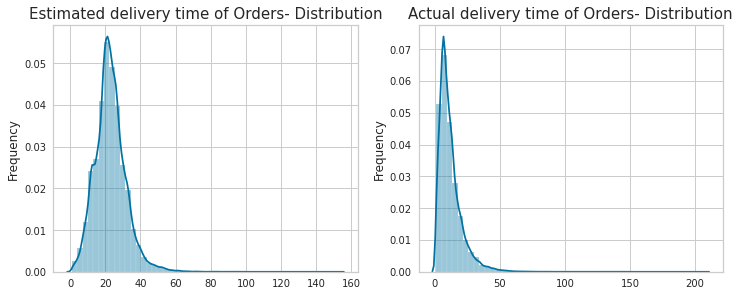

In [ ]:
plot_feature(df_regression['estimated_delivery_time'], "Estimated delivery time of Orders", df_regression['actual_delivery_time'], "Actual delivery time of Orders")

In [ ]:
df_regression['estimated_delivery_time'] = np.log1p(df_regression['estimated_delivery_time'])
df_regression['actual_delivery_time'] = np.log1p(df_regression['actual_delivery_time'])

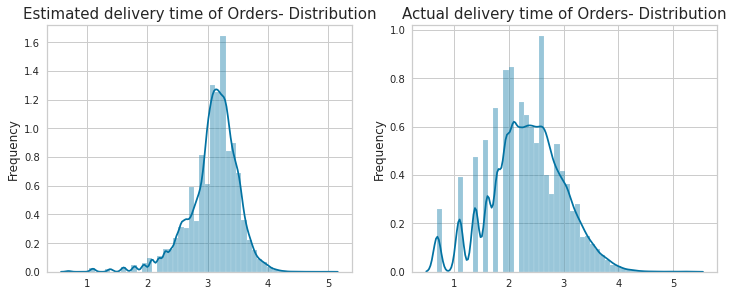

In [ ]:
plot_feature(df_regression['estimated_delivery_time'], "Estimated delivery time of Orders", df_regression['actual_delivery_time'], "Actual delivery time of Orders")

In [ ]:
print("Skewness: \n",df_regression.skew(),"\n")
print("Kurtosis: \n",df_regression.kurtosis(),"\n")

Skewness: 
 price                         0.316941
freight_value                 0.159494
product_description_lenght    1.992794
product_photos_qty            1.859429
review_score                 -1.398314
estimated_delivery_time      -1.032132
actual_delivery_time         -0.104538
dtype: float64 

Kurtosis: 
 price                         0.397671
freight_value                 5.286240
product_description_lenght    4.839593
product_photos_qty            4.587948
review_score                  0.632399
estimated_delivery_time       2.858334
actual_delivery_time          0.131633
dtype: float64 



**Removing outliers**

**Actual delivery time**

In [ ]:
def plot_outlier_features(data):
  sns.set(style="whitegrid")
  fig, ax = plt.subplots(figsize=(12,5))
  bxpt = sns.boxplot(x= data, ax=ax) #df_regression['actual_delivery_time']

  print(data.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))

0.0    0.693147
0.1    1.386294
0.2    1.791759
0.3    2.079442
0.4    2.197225
0.5    2.302585
0.6    2.484907
0.7    2.708050
0.8    2.890372
0.9    3.178054
1.0    5.342334
Name: actual_delivery_time, dtype: float64


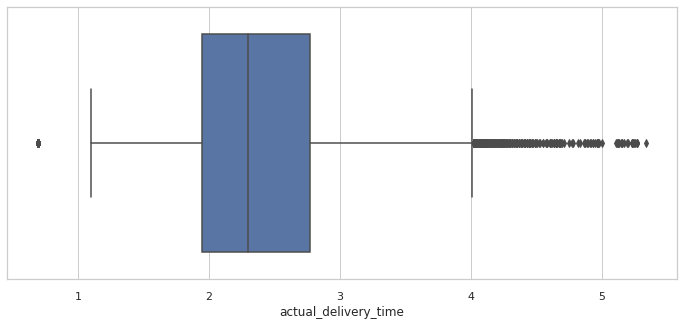

In [ ]:
plot_outlier_features(df_regression['actual_delivery_time'])

In [ ]:
def imputer(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    lower_bound  = q1-1.5*iqr
    upper_bound = q3+1.5*iqr
    print('Lower bound: ', lower_bound)
    print('Upper bound: ', upper_bound)
    df_regression[col_name] = data[col_name].clip(lower_bound, upper_bound)
    return df_regression

In [ ]:
df_regression = imputer(df_regression, 'actual_delivery_time')

Lower bound:  0.7058922892786115
Upper bound:  4.012606582016483


In [ ]:
print(df_regression['actual_delivery_time'].min())
print(df_regression['actual_delivery_time'].max())

0.7058922892786115
4.012606582016483


0.0    0.705892
0.1    1.386294
0.2    1.791759
0.3    2.079442
0.4    2.197225
0.5    2.302585
0.6    2.484907
0.7    2.708050
0.8    2.890372
0.9    3.178054
1.0    4.012607
Name: actual_delivery_time, dtype: float64


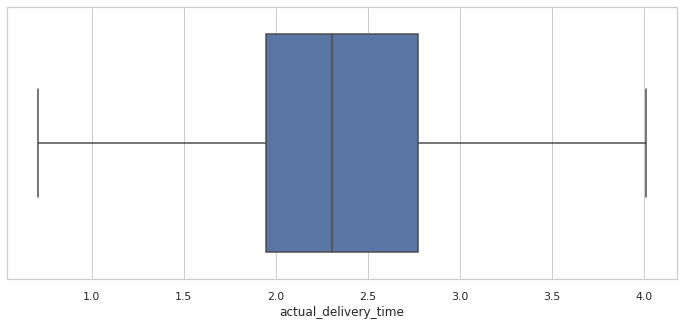

In [ ]:
plot_outlier_features(df_regression['actual_delivery_time'])

No outliers after mean imputation. We did this because according to our ecommerce knowledge from google, delivery times for all the orders are the same approximately.

**estimated_delivery_time**

0.0    0.693147
0.1    2.564949
0.2    2.833213
0.3    2.995732
0.4    3.091042
0.5    3.135494
0.6    3.218876
0.7    3.295837
0.8    3.401197
0.9    3.526361
1.0    5.036953
Name: estimated_delivery_time, dtype: float64


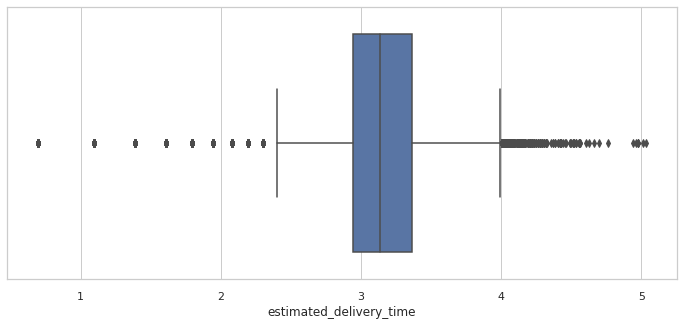

In [ ]:
plot_outlier_features(df_regression['estimated_delivery_time'])

In [ ]:
df_regression = imputer(df_regression, 'estimated_delivery_time')

Lower bound:  2.3101537029363897
Upper bound:  4.001581106216525


In [ ]:
print(df_regression['estimated_delivery_time'].min())
print(df_regression['estimated_delivery_time'].max())

2.3101537029363897
4.001581106216525


0.0    2.310154
0.1    2.564949
0.2    2.833213
0.3    2.995732
0.4    3.091042
0.5    3.135494
0.6    3.218876
0.7    3.295837
0.8    3.401197
0.9    3.526361
1.0    4.001581
Name: estimated_delivery_time, dtype: float64


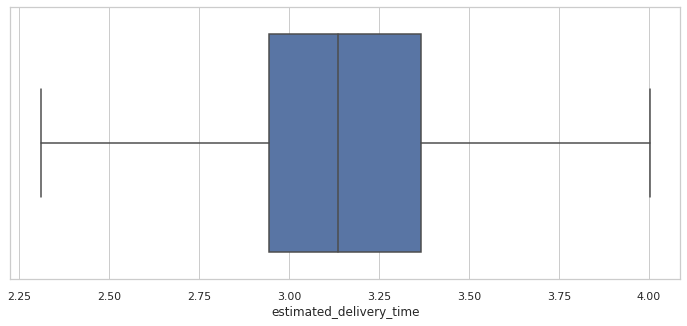

In [ ]:
plot_outlier_features(df_regression['estimated_delivery_time'])

**Product Photo quality**

In [ ]:
df_regression['product_photos_qty'] = df_regression['product_photos_qty'].round(0).astype(int)

0.0     1.0
0.1     1.0
0.2     1.0
0.3     1.0
0.4     1.0
0.5     2.0
0.6     2.0
0.7     3.0
0.8     3.0
0.9     5.0
1.0    20.0
Name: product_photos_qty, dtype: float64


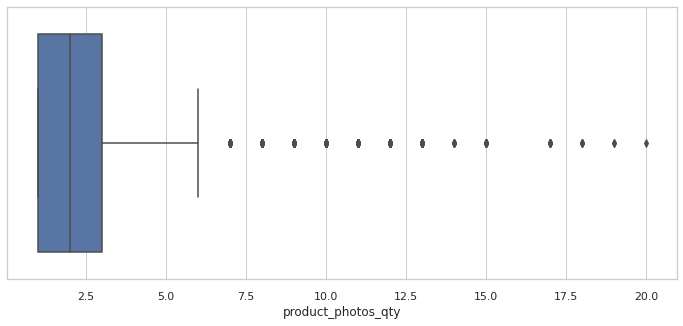

In [ ]:
plot_outlier_features(df_regression['product_photos_qty'])

In [ ]:
df_regression = imputer(df_regression, 'product_photos_qty')

Lower bound:  -2.0
Upper bound:  6.0


0.0    1.0
0.1    1.0
0.2    1.0
0.3    1.0
0.4    1.0
0.5    2.0
0.6    2.0
0.7    3.0
0.8    3.0
0.9    5.0
1.0    6.0
Name: product_photos_qty, dtype: float64


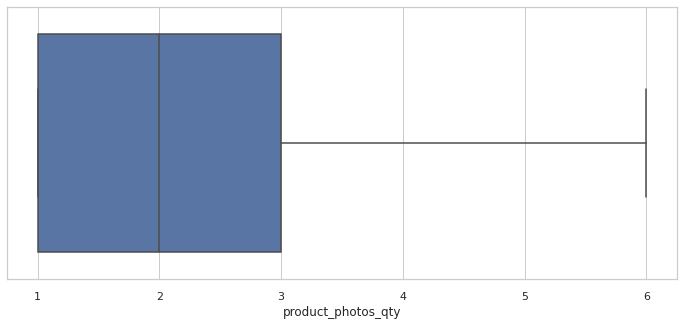

In [ ]:
plot_outlier_features(df_regression['product_photos_qty'])

**Freight Value**

0.0    0.000000
0.1    2.297573
0.2    2.601207
0.3    2.714695
0.4    2.783776
0.5    2.856470
0.6    2.941804
0.7    3.021887
0.8    3.194173
0.9    3.560478
1.0    6.017814
Name: freight_value, dtype: float64


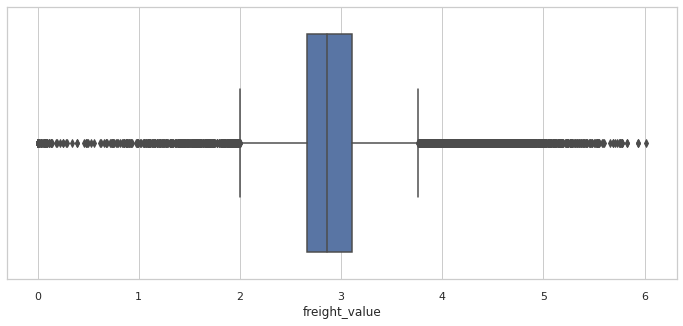

In [ ]:
plot_outlier_features(df_regression['freight_value'])

In [ ]:
df_regression = imputer(df_regression, 'freight_value')

Lower bound:  2.003167634417409
Upper bound:  3.7647204551859983


0.0    2.003168
0.1    2.297573
0.2    2.601207
0.3    2.714695
0.4    2.783776
0.5    2.856470
0.6    2.941804
0.7    3.021887
0.8    3.194173
0.9    3.560478
1.0    3.764720
Name: freight_value, dtype: float64


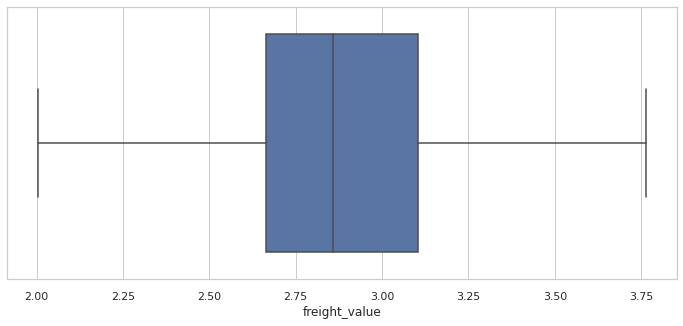

In [ ]:
plot_outlier_features(df_regression['freight_value'])

Dividing customer state into 5 regions of Brazil

In [ ]:
north = ['AC','AP','AM','PA','RO','RR','TO']
north_east = ['AL','BA','CE','MA','PB','PE','PI','RN','SE']
center_west = ['DF','GO','MT','MS']
south_east = ['ES','MG','RJ','SP']
south = ['PR','RS','SC']

In [ ]:
df_regression.loc[df_regression['customer_state'].isin(north), 'customer_regions'] = 'north'
df_regression.loc[df_regression['customer_state'].isin(north_east), 'customer_regions'] = 'north_east'
df_regression.loc[df_regression['customer_state'].isin(center_west), 'customer_regions'] = 'center_west'
df_regression.loc[df_regression['customer_state'].isin(south_east), 'customer_regions'] = 'south_east'
df_regression.loc[df_regression['customer_state'].isin(south), 'customer_regions'] = 'south'

In [ ]:
df_regression.head()

,price,freight_value,customer_state,product_description_lenght,product_photos_qty,review_score,product_category_name_english,estimated_delivery_time,actual_delivery_time,customer_regions
0,3.433665,2.274186,SP,268.0,4.0,4,housewares,2.772589,2.197225,south_east
1,3.433665,2.172476,SP,268.0,4.0,4,housewares,2.564949,1.098612,south_east
2,3.433665,2.172476,SP,268.0,4.0,5,housewares,2.564949,1.609438,south_east
3,3.433665,2.714695,SC,268.0,4.0,3,housewares,2.944439,2.639057,south
4,5.828946,2.897016,SP,664.0,6.0,1,housewares,3.258097,3.526361,south_east


Dividing product_category_name into category types

In [ ]:
home_personal = ['bed_bath_table', 'housewares', 'food_drink', 'kitchen_dining_laundry_garden_furniture', 'home_confort', 'home_comfort_2', 
                 'food', 'christmas_supplies', 'drinks', 'health_beauty', 'bed_bath_table', 'perfumery', 'watches_gifts', 'flowers', 
                 'party_supplies', 'auto', 'pet_shop', 'cine_photo', 'la_cuisine']

entertainment_stationary = ['audio', 'books_technical', 'musical_instruments', 'books_general_interest', 'art', 'books_imported', 'music',
                              'arts_and_craftmanship', 'stationery', 'consoles_games', 'cool_stuff']

electronics_furniture = ['computers_accessories', 'furniture_decor', 'telephony', 'tablets_printing_image', 'fixed_telephony', 
                         'small_appliances', 'air_conditioning', 'office_furniture', 'electronics', 'home_appliances',
                         'furniture_living_room', 'home_construction', 'furniture_mattress_and_upholstery', 'furniture_bedroom',
                         'signaling_and_security', 'computers', 'home_appliances_2', 'small_appliances_home_oven_and_coffee', 
                         'cds_dvds_musicals', 'dvds_blu_ray', 'security_and_services']

garden_construction_idustry = ['garden_tools', 'construction_tools_construction', 'costruction_tools_garden', 'costruction_tools_tools',
                               'construction_tools_lights', 'construction_tools_safety', 'market_place',  'agro_industry_and_commerce',  
                               'industry_commerce_and_business',]

fashion_clothing = ['sports_leisure', 'baby', 'toys', 'fashion_bags_accessories', 'fashion_shoes', 'luggage_accessories',
                            'fashion_male_clothing', 'fashion_underwear_beach', 'fashion_sport', 'fashio_female_clothing',
                            'diapers_and_hygiene', 'fashion_childrens_clothes']

In [ ]:
df_regression.loc[df_regression['product_category_name_english'].isin(home_personal), 'product_category_type'] = 'home_personal'
df_regression.loc[df_regression['product_category_name_english'].isin(entertainment_stationary), 'product_category_type'] = 'entertainment_stationary'
df_regression.loc[df_regression['product_category_name_english'].isin(electronics_furniture), 'product_category_type'] = 'electronics_furniture'
df_regression.loc[df_regression['product_category_name_english'].isin(garden_construction_idustry), 'product_category_type'] = 'garden_construction_idustry'
df_regression.loc[df_regression['product_category_name_english'].isin(fashion_clothing), 'product_category_type'] = 'fashion_clothing'

In [ ]:
df_regression.head()

,price,freight_value,customer_state,product_description_lenght,product_photos_qty,review_score,product_category_name_english,estimated_delivery_time,actual_delivery_time,customer_regions,product_category_type
0,3.433665,2.274186,SP,268.0,4.0,4,housewares,2.772589,2.197225,south_east,home_personal
1,3.433665,2.172476,SP,268.0,4.0,4,housewares,2.564949,1.098612,south_east,home_personal
2,3.433665,2.172476,SP,268.0,4.0,5,housewares,2.564949,1.609438,south_east,home_personal
3,3.433665,2.714695,SC,268.0,4.0,3,housewares,2.944439,2.639057,south,home_personal
4,5.828946,2.897016,SP,664.0,6.0,1,housewares,3.258097,3.526361,south_east,home_personal


In [ ]:
# Lets remove the columns that we have aggregated from: customer_state and product_category_name

df_regression = df_regression.drop(['customer_state','product_category_name_english'], axis=1)
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96282 entries, 0 to 96515
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       96282 non-null  float64
 1   freight_value               96282 non-null  float64
 2   product_description_lenght  96282 non-null  float64
 3   product_photos_qty          96282 non-null  float64
 4   review_score                96282 non-null  int64  
 5   estimated_delivery_time     96282 non-null  float64
 6   actual_delivery_time        96282 non-null  float64
 7   customer_regions            96282 non-null  object 
 8   product_category_type       96282 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 7.3+ MB


**Training and Testing data**

In [ ]:
X = df_regression.iloc[:,:-1]
y = df_regression['actual_delivery_time']

In [ ]:
# turn X into dict
X_dict = X.to_dict(orient='records') # turn each row as key-value pairs
X_dict[0]

{'actual_delivery_time': 2.1972245773362196,
 'customer_regions': 'south_east',
 'estimated_delivery_time': 2.772588722239781,
 'freight_value': 2.2741856184723477,
 'price': 3.433664571799657,
 'product_description_lenght': 268.0,
 'product_photos_qty': 4.0,
 'review_score': 4}

In [ ]:
# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse=False) 
# sparse = False means the output is not a sparse matrix
# apply dv_X on X_dict
X_encoded = dv_X.fit_transform(X_dict)
# show X_encoded
X_encoded

array([[  2.19722458,   0.        ,   0.        , ..., 268.        ,
          4.        ,   4.        ],
       [  1.09861229,   0.        ,   0.        , ..., 268.        ,
          4.        ,   4.        ],
       [  1.60943791,   0.        ,   0.        , ..., 268.        ,
          4.        ,   5.        ],
       ...,
       [  1.38629436,   0.        ,   0.        , ..., 660.        ,
          3.        ,   3.        ],
       [  2.99573227,   0.        ,   1.        , ..., 506.        ,
          1.        ,   4.        ],
       [  2.30258509,   1.        ,   0.        , ..., 461.        ,
          4.        ,   1.        ]])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_encoded, y, test_size = 0.3, random_state = 123)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(67397, 12) (28885, 12) (67397,) (28885,)


**Linear Regression**

In [ ]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)
y_pred

array([3.55534806, 2.30258509, 2.19722458, ..., 1.09861229, 2.30258509,
       3.73766962])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_train = regressor.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)
score_train = r2_score(y_train,y_pred_train)
print("Train score: ", score_train)

RMSE Train:  4.1658930634863124e-13
Train score:  1.0


**RandomForestRegressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=7).fit(X_train, y_train)
y_prediction = rfr.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_train = rfr.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)
score_train = r2_score(y_train,y_pred_train)
print("Train score: ", score_train)

RMSE Train:  0.000569112309379903
Train score:  0.9999992501511451


**KNNRegressor**

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(X_train,y_train)
model.best_params_

{'n_neighbors': 4}

In [ ]:
model = neighbors.KNeighborsRegressor(n_neighbors = 3)
model.fit(X_train, y_train)
pred=model.predict(X_test)

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)
score_train = r2_score(y_train,y_pred_train)
print("Train score: ", score_train)

RMSE Train:  0.2553753899390616
Train score:  0.8490142849998566


**MLPRegressor**

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
y_prediction = regr.predict(X_test)

In [ ]:
y_pred_train = regr.predict(X_train)
y_pred_train
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("RMSE Train: ", rmse_train)
score_train = r2_score(y_train,y_pred_train)
print("Train score: ", score_train)

RMSE Train:  0.40454648588136766
Train score:  0.6211086937622696


**MullerLoop using same algorithms**

In [ ]:
names = ["LinearRegression", "RandomForestRegressor", "neighbors", "MLPRegressor"]

In [ ]:
regressors = [
    LinearRegression(),
    RandomForestRegressor(max_depth=7),
    neighbors.KNeighborsRegressor(n_neighbors = 3),
    MLPRegressor(random_state=1, max_iter=500)]

In [ ]:
max_score = 0.0
max_class = ''
# iterate over classifiers
for name, rgs in zip(names, regressors):
    rgs.fit(X_train, y_train)
    score = 100.0 * rgs.score(X_test, y_test)
    print('Regressor = %s, Score (test, accuracy) = %.2f,' %(name, score))
    
    if score > max_score:
        clf_best = rgs
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Regressor = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

Regressor = LinearRegression, Score (test, accuracy) = 100.00,
Regressor = RandomForestRegressor, Score (test, accuracy) = 100.00,
Regressor = neighbors, Score (test, accuracy) = 67.67,
Regressor = MLPRegressor, Score (test, accuracy) = 62.49,
--------------------------------------------------------------------------------
Best --> Regressor = LinearRegression, Score (test, accuracy) = 100.00


# **Classification:**


Upon analyzing and segmenting the customers based on their buying pattern, we are classifying customers based on their total worth to a business over the whole period of their relationship (Customer Lifetime Value)

**Feature Extraction**

In [ ]:
#converting the type of Invoice Date Field from string to datetime.
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [ ]:
# considering 6 months data
df_6m = df[(df.order_purchase_timestamp >= pd.to_datetime('2017-6-1')) & (df.order_purchase_timestamp  < pd.to_datetime('2017-12-1'))].reset_index(drop=True)

In [ ]:
#calculate revenue and create a new dataframe for it
df_6m['Revenue'] = df_6m['price'] * df_6m['order_item_id']
orders_user_6m = df_6m.groupby('customer_unique_id')['Revenue'].sum().reset_index()
orders_user_6m.columns = ['customer_unique_id','m6_Revenue']

In [ ]:
# merging 6 months data along with the classification dataset r_percentile
df_classification = df[['recency', 'frequency', 'monetary', 'r_percentile', 'f_percentile', 'm_percentile', 'RFM_Score_s', 'clusters', 'customer_unique_id','RFM_Level']]
df_classification = pd.merge(df_classification, orders_user_6m, on='customer_unique_id', how='left')

In [ ]:
# df_classification = df_classification.fillna(0)
df_classification.replace(np.nan, 0)

,recency,frequency,monetary,r_percentile,f_percentile,m_percentile,RFM_Score_s,clusters,customer_unique_id,RFM_Level,m6_Revenue
0,335,2,62.23,0.271575,0.983768,0.255321,7.0,3,7c396fd4830fd04220f754e42b4e5bff,Loyal,65.38
1,383,1,37.77,0.204672,0.484978,0.095941,12.0,2,3a51803cc0d012c3b5dc8b7528cb05f7,Can't Loose Them,29.99
2,396,1,37.77,0.187042,0.484978,0.095941,12.0,2,ef0996a1a279c26e7ecbd737be23d235,Can't Loose Them,29.99
3,314,1,44.09,0.303637,0.484978,0.136880,11.0,2,e781fdcc107d13d865fc7698711cc572,Can't Loose Them,29.99
4,282,1,356.12,0.362044,0.484978,0.919124,8.0,4,3e4fd73f1e86b135b9b121d6abbe9597,Champions,339.00
...,...,...,...,...,...,...,...,...,...,...,...
96511,133,1,34.22,0.710154,0.484978,0.071047,10.0,1,4637328fb3cc446c747c7f83f80c651d,Can't Loose Them,0.00
96512,30,1,33.69,0.940040,0.484978,0.066941,9.0,1,c887bc0b0717ee4a21d7d22137f12ee3,Can't Loose Them,0.00
96513,41,1,84.63,0.910280,0.484978,0.394674,8.0,0,8d80e477643ec569b24592ce3d9dfc4c,Champions,0.00
96514,584,1,209.06,0.007929,0.484978,0.802968,9.0,4,d8bee9ec375c3a0f9ef8ed7456a51dcd,Can't Loose Them,0.00


In [ ]:
#remove outliers
df_classification = df_classification[df_classification['m6_Revenue']<df_classification['m6_Revenue'].quantile(0.99)]

from sklearn.cluster import KMeans

#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_classification[['m6_Revenue']])
df_classification['LTVCluster'] = kmeans.predict(df_classification[['m6_Revenue']])

In [ ]:
df_classification.dtypes

recency                 int64
frequency               int64
monetary              float64
r_percentile          float64
f_percentile          float64
m_percentile          float64
RFM_Score_s           float64
clusters                int32
customer_unique_id     object
RFM_Level              object
m6_Revenue            float64
LTVCluster              int32
dtype: object

LTVCluster feature is extracted by clustering customers based on their revenue from past 6 month snad that is used as a target feature. It tells us if the customer is valuable for the business or not

**Feature Selection**

[Feature Selection Technique](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)

In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = df_classification.drop(['LTVCluster','m6_Revenue', 'customer_unique_id'],axis=1)
X = pd.get_dummies(X)
y = df_classification['LTVCluster']

**Pearson’s correlation**

In [ ]:
num_feats = 8

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

cor_support, cor_feature = cor_selector(X, y,num_feats)

print(str(len(cor_feature)), 'selected features')
print(cor_feature)

8 selected features
['frequency', 'RFM_Level_Promising', 'monetary', "RFM_Level_Can't Loose Them", 'RFM_Level_Champions', 'RFM_Score_s', 'clusters', 'm_percentile']


**Chi-squared Test**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

print(str(len(chi_feature)), 'selected features')
print(chi_feature)

8 selected features
['monetary', 'f_percentile', 'm_percentile', 'RFM_Score_s', 'clusters', "RFM_Level_Can't Loose Them", 'RFM_Level_Champions', 'RFM_Level_Promising']


**Recursive Feature Elimination**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 15 features.
8 selected features
['monetary', 'r_percentile', 'f_percentile', 'm_percentile', 'RFM_Score_s', 'clusters', "RFM_Level_Can't Loose Them", 'RFM_Level_Champions']


**Lasso : SelectFromModel**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
embeded_lr_selector.fit(X_norm, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()

print(str(len(embeded_lr_feature)), 'selected features')
print(embeded_lr_feature)

4 selected features
['monetary', 'r_percentile', 'm_percentile', 'clusters']


**Tree-based: SelectFromModel**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

print(str(len(embeded_lgb_feature)), 'selected features')
print(embeded_lgb_feature)

4 selected features
['recency', 'monetary', 'r_percentile', 'm_percentile']


**Using RandomForest**

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

3 selected features
['monetary', 'm_percentile', 'RFM_Score_s']


**Aggregation of all feature selection methods**

In [ ]:
feature_name = X.columns
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,Total
1,monetary,True,True,True,True,True,True,6
2,m_percentile,True,True,True,True,True,True,6
3,clusters,True,True,True,True,False,False,4
4,RFM_Score_s,True,True,True,False,True,False,4
5,r_percentile,False,False,True,True,False,True,3
6,RFM_Level_Champions,True,True,True,False,False,False,3
7,RFM_Level_Can't Loose Them,True,True,True,False,False,False,3
8,f_percentile,False,True,True,False,False,False,2


**Splitting data into training, testing and validation**

In [ ]:
X_train, X_rem, y_train, y_rem = train_test_split(X[['monetary','m_percentile','clusters', 'RFM_Score_s', 'r_percentile']],y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.1)

**Modeling : MullerLoop**

In [ ]:
names = ["Random Forest", "AdaBoost", "MLP Classifier", "Decision Tree"]

In [ ]:
classifier = [
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    DecisionTreeClassifier(max_depth=5)]

In [ ]:
max_score = 0.0
max_class = ''
clf_list = []
# iterate over classifiers
for name, clf in zip(names, classifier):
    clf_model = name + "_model"
    clf_model = clf.fit(X_train, y_train)
    score = 100.0 * clf_model.score(X_test, y_test)
    print('classifier = %s, Score (test, accuracy) = %.2f,' %(name, score))
    clf_list.append(clf_model)

    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(clf_list)
print(80*'-' )
print('Best --> classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

classifier = Random Forest, Score (test, accuracy) = 91.32,
classifier = AdaBoost, Score (test, accuracy) = 91.14,
classifier = MLP Classifier, Score (test, accuracy) = 88.79,
classifier = Decision Tree, Score (test, accuracy) = 91.68,
[RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10), AdaBoostClassifier(), MLPClassifier(alpha=1, max_iter=1000), DecisionTreeClassifier(max_depth=5)]
--------------------------------------------------------------------------------
Best --> classifier = Decision Tree, Score (test, accuracy) = 91.68


# **Interactive Dashboard**

1. Using Holoviz - widgets
2. Using ExplainerDashboard

**Using Holoviz**

In [ ]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'Mid-level', 
                                        1: 'Low-level', 
                                        2: 'High-level'})                                    
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    return visualizer

In [ ]:
def muller(X,y):
  names = ["Nearest Neighbors",
          "Decision Tree", "Random Forest", "AdaBoost",
          "Naive Bayes"]
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
  classifiers = [
      KNeighborsClassifier(3),
      DecisionTreeClassifier(),
      RandomForestClassifier(n_estimators=10, max_features=1),
      AdaBoostClassifier(),
      GaussianNB()]
  max_score = 0.0
  max_class = ''
  # iterate over classifiers
  for name, clf in zip(names, classifiers):
      start_time = time()
      clf.fit(X_train, y_train)
      score = 100.0 * clf.score(X_test, y_test)
      print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time() - start_time))
      if score > max_score:
          clf_best = clf
          max_score = score
          max_class = name

  print(80*'-' )
  print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
  return clf_best,X_test,y_test,X_train,y_train

In [ ]:
def on_button_clicked(b):
  fig, ax = plt.subplots(1,2)
  global new_X
  global y
  global checkbox
  only_selected_values=[]

  for x in checkbox:
    if checkbox[x].value==True:
      only_selected_values.append(checkbox[x].description)

  final_X = X.loc[:,only_selected_values]

  oversample = SMOTE()
  resampled_X, resampled_y = oversample.fit_resample(final_X,y)

  original_class_distribution = Counter(resampled_y)
  strategy = {0:original_class_distribution[0]+round((slider1.value/100)*len(resampled_X)), 1:original_class_distribution[1]+round((slider2.value/100)*len(resampled_X)), 2:original_class_distribution[2]+round((slider3.value/100)*len(resampled_X))}
  
  oversample1 = SMOTE(sampling_strategy=strategy)
  
  resampled_X1, resampled_y1 = oversample1.fit_resample(resampled_X,resampled_y)
  
  best_classifier,X_test, y_test,X_train,y_train = muller(resampled_X1,resampled_y1)
  
  plot_confusion_matrix(best_classifier,X_test,y_test,ax=ax[0])
  plot_ROC_curve(best_classifier,X_train,y_train,X_test,y_test)
  plt.show()

In [ ]:
slider1 = widgets.IntSlider(min=0, max=100,description='Class 0',step=1)
slider2 = widgets.IntSlider(min=0, max=100,description='Class 1',step=1)
slider3 = widgets.IntSlider(min=0, max=100,description='Class 2',step=1)

print("Select Percentage of data distribution")
display(slider1,slider2,slider3)

Select Percentage of data distribution


IntSlider(value=0, description='Class 0')

IntSlider(value=0, description='Class 1')

IntSlider(value=0, description='Class 2')

In [ ]:
checkbox={}
for x in X.columns:
    checkbox[x]=widgets.Checkbox(value=True,description=x)

print("Features selection for analysis")
for x in checkbox:
  display(checkbox[x])

Features selection for analysis


Checkbox(value=True, description='recency')

Checkbox(value=True, description='frequency')

Checkbox(value=True, description='monetary')

Checkbox(value=True, description='r_percentile')

Checkbox(value=True, description='f_percentile')

Checkbox(value=True, description='m_percentile')

Checkbox(value=True, description='RFM_Score_s')

Checkbox(value=True, description='clusters')

Checkbox(value=True, description="RFM_Level_Can't Loose Them")

Checkbox(value=True, description='RFM_Level_Champions')

Checkbox(value=True, description='RFM_Level_Loyal')

Checkbox(value=True, description='RFM_Level_Needs Attention')

Checkbox(value=True, description='RFM_Level_Potential')

Checkbox(value=True, description='RFM_Level_Promising')

Checkbox(value=True, description='RFM_Level_Require Activation')

Button(description='Compute Metrics', style=ButtonStyle())

Classifier = Nearest Neighbors, Score (test, accuracy) = 96.94, Training time = 1.30 seconds
Classifier = Decision Tree, Score (test, accuracy) = 96.44, Training time = 1.32 seconds
Classifier = Random Forest, Score (test, accuracy) = 97.01, Training time = 2.06 seconds
Classifier = AdaBoost, Score (test, accuracy) = 92.19, Training time = 6.86 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 89.90, Training time = 0.05 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest, Score (test, accuracy) = 97.01


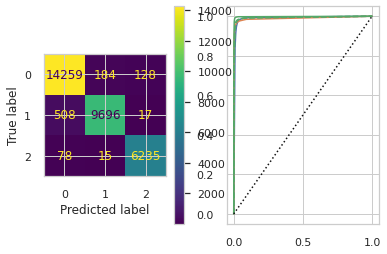

In [ ]:
button = widgets.Button(description="Compute Metrics")
button.on_click(on_button_clicked)
display(button)

**Using Explainer dashboard**

In [ ]:
df_sample = df_classification.sample(1000)
X = df_sample[['recency','r_percentile','monetary', 'm_percentile', 'clusters']]
y = df_sample['LTVCluster']

X_train_sam, X_test_sam, y_train_sam, y_test_sam = train_test_split(X,y, train_size=0.8)

In [ ]:
!pip install explainerdashboard

     |████████████████████████████████| 305 kB 5.4 MB/s 
     |████████████████████████████████| 61 kB 158 kB/s 
     |████████████████████████████████| 57 kB 2.9 MB/s 
     |████████████████████████████████| 197 kB 39.9 MB/s 
     |████████████████████████████████| 255 kB 25.4 MB/s 
     |████████████████████████████████| 470 kB 38.7 MB/s 
     |████████████████████████████████| 564 kB 19.4 MB/s 
     |████████████████████████████████| 9.6 MB 26.5 MB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
     |████████████████████████████████| 357 kB 34.2 MB/s 
     |████████████████████████████████| 136 kB 62.2 MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.5-py3-none-any.whl size=67330 sha256=63abf8ffe625ab277d30a8191ba3e7297d9efbd35eb13db0ddd33aec479cfdf5
  Stored in directory: /root/.cache/pip/wheels/9d/84/55/4de0a214e0b9d21a96fc343b4a85547f3dab815a49682dfeb2
  Created wheel for dash-auth: filename=dash_auth-1.4.1-py3-none-any.whl size=476152 sha256=4ef6073594e58258

In [ ]:
from explainerdashboard import ClassifierExplainer,ExplainerDashboard,ExplainerHub
explainer_clf_1 = ClassifierExplainer(clf_list[0], X_train_sam,y_train_sam)
explainer_clf_2 = ClassifierExplainer(clf_list[1], X_train_sam,y_train_sam, shap='kernel')
explainer_clf_3 = ClassifierExplainer(clf_list[2], X_train_sam,y_train_sam, shap='kernel')
explainer_clf_4 = ClassifierExplainer(clf_list[3], X_train_sam,y_train_sam)

Detected RandomForestClassifier model: Changing class type to RandomForestClassifierExplainer...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Note: model_output=='probability', so assuming that raw shap output of DecisionTreeClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)


In [ ]:
db1 = ExplainerDashboard(explainer_clf_1, shap_interaction=False, title="Random Forest", name="Random Forest")
db2 = ExplainerDashboard(explainer_clf_2, shap_interaction=False, title="AdaBoost", name="AdaBoost")
db3 = ExplainerDashboard(explainer_clf_3, shap_interaction=False, title="MLP Classifier", name="MLP Classifier")
db4 = ExplainerDashboard(explainer_clf_4, shap_interaction=False, title="Decision Tree", name="Decision Tree")

Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calcula

  0%|          | 0/800 [00:00<?, ?it/s]

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/800 [00:00<?, ?it/s]

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Building ExplainerDashboard..
Detected google colab environment, setting mode='external'
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc 

In [ ]:
db1.run(port=8050, host = '127.0.0.1', mode="inline")

Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8050))


<IPython.core.display.Javascript object>

In [ ]:
db2.run(port=8051, host = '127.0.0.1', mode="inline")

Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8051))


<IPython.core.display.Javascript object>

In [ ]:
db3.run(port=8052, host = '127.0.0.1', mode="inline")

Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8052))


<IPython.core.display.Javascript object>

In [ ]:
db4.run(port=8053, host = '127.0.0.1', mode="inline")

Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8053))


<IPython.core.display.Javascript object>